# Face Recognition with Raspberry Pi
Prof. Yonggang Wen, TA: Huaizheng Zhang, Weizheng HU

## Part_1 Prepare your training images
In the first part, you need to transform your training images by using different methods like rotate, crop and so on so that you can have more images to train your model and make your model more robust.  The processing is called data augmentation. For example, if you only use front face to train, when the camera just detects a part of face it may not recognize it).


In [16]:
import tensorflow as tf
import numpy as np
import cv2
import os
import keras
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
import keras.backend as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

#### 1.1 Let's see what is data augmentation

(2320, 3088, 3)
(1, 2320, 3088, 3)


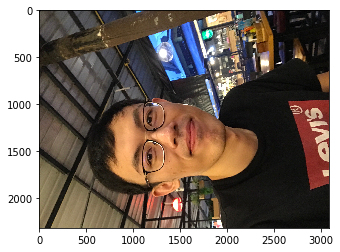

In [17]:
img = load_img('face_data/ZhangHuaizheng/ZhangHuaizheng001.jpeg')  # this is a PIL image
imshow(img)
test_1 = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
print test_1.shape
test_1 = test_1.reshape((1, ) + test_1.shape) # this is a Numpy array with shape (1, 3, 150, 150)
print test_1.shape

#### 1.2 Process all face images.

In [ ]:
NAME = ['ZhouXin', 'YiDeliang', 'WangYongjie', 'ZhangHuaizheng', 'LuoYong']
datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        rescale=0.5,
        fill_mode='nearest')
  

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `aug_data/` directory
for name in NAME:
    for number in range(1, 6):
        temp = load_img('face_data/' + name + '/' + name + '00' + str(number) + '.jpeg')
        img_arr = img_to_array(temp)
        img_arr = img_arr.reshape((1, ) + img_arr.shape)
        i = 0
        for batch in datagen.flow(img_arr, batch_size=1,
                                  save_to_dir='aug_data/'+ name, save_prefix=name + str(number), save_format='jpeg'):
            i += 1
            if i > 99:
                break

## Part_2 Build your deep learning model to recognize people

In [18]:
def model(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(32, (3, 3), )(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(32, (3, 3), )(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Conv2D(64, (3, 3), )(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    
    X = Flatten()(X)
    X = Dense(64)(X)
    X = Activation('relu')(X)
    X = Dropout(0.5)(X)
    X = Dense(6)(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs=X_input, outputs=X, name='FaceModel')
    
    return model

#### Creat and compile your model to prepare to train

In [19]:
FaceModel = model((150, 150, 3))
FaceModel.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

## Part_3 Train you model

#### Prepare your data and split them to training set and validation set

## Part_2 Detect the face from your training image
After the first step, we have many training images now. We want to implement a face recognition system so we need to do face detection first. Then we extract the face from the image and use this face to train our recognition model. The detection algorithm called LBP which is very fast. If you want to know more details about it you can check the reference.

In [ ]:
def detect_face(image_dir, classifier):
    allfile = [f for f in os.listdir(path)]

In [6]:
face_cascade = cv2.CascadeClassifier('opencv/data/haarcascades/haarcascade_frontalface_default.xml')
lbp_face_cascade = cv2.CascadeClassifier('opencv/data/lbpcascades/lbpcascade_frontalface.xml')  

In [24]:
def thresholded(center, pixels):
    out = []
    for a in pixels:
        if a >= center:
            out.append(1)
        else:
            out.append(0)
    return out


def get_pixel_else_0(l, idx, idy, default=0):
    try:
        return l[idx, idy]
    except IndexError:
        return default

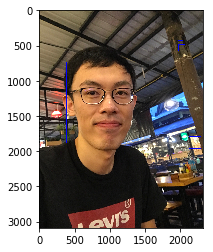

In [11]:
img = cv2.imread('face_data/ZhangHuaizheng/ZhangHuaizheng001.jpeg')
newgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

face = face_cascade.detectMultiScale(newgray,
                                    scaleFactor=1.1,
                                    minNeighbors=5,
                                    minSize=(30, 30),
                                    )
for (x, y, w, h) in face:
#    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = newgray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# cropped = newgray[y:y+h, x:x+w]
# result = cv2.resize(cropped, (48, 48), interpolation=cv2.INTER_LINEAR)
# transformed_img = cv2.copyMakeBorder(result, 0, 0, 0, 0, cv2.BORDER_REPLICATE)

# for x in range(0, len(result)):
#     for y in range(0, len(result[0])):
#         center = result[x, y]
#         top_left = get_pixel_else_0(result, x - 1, y - 1)
#         top_up = get_pixel_else_0(result, x, y - 1)
#         top_right = get_pixel_else_0(result, x + 1, y - 1)
#         right = get_pixel_else_0(result, x + 1, y)
#         left = get_pixel_else_0(result, x - 1, y)
#         bottom_left = get_pixel_else_0(result, x - 1, y + 1)
#         bottom_right = get_pixel_else_0(result, x + 1, y + 1)
#         bottom_down = get_pixel_else_0(result, x, y + 1)
#         values = thresholded(center, [top_left, top_up, top_right, right, 
#                                       bottom_right,bottom_down, bottom_left, left])
#         weights = [1, 2, 4, 8, 16, 32, 64, 128]
#         res = 0
#         for a in range(0, len(values)):
#             res += weights[a] * values[a]
#         transformed_img.itemset((x, y), res)
# lbp = transformed_img[1:47, 1:47]
# imshow(lbp)

In [5]:
lbp_face_cascade = cv2.CascadeClassifier('opencv/data/lbpcascades/lbpcascade_frontalface.xml')  
 
#load test image 
test2 = cv2.imread('face_data/ZhangHuaizheng/ZhangHuaizheng004.jpeg') 
 
#call our function to detect faces 
faces_detected_img = detect_faces(lbp_face_cascade, test2)  
 
#convert image to RGB and show image imshow(convertToRGB(faces_detected_img))

NameError: name 'detect_faces' is not defined

### Reference
1. Building powerful image classification models using very little data.
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
2. realtime face recognition with deep learning in python. https://github.com/Minalinskyy/face-recognition-with-deep-learning-python